# Time Series in Python 
# Practical approach
# Методы сглаживания , Arima, Sarima


In [13]:
import numpy as np                               # работа с векторами и матрицами
import pandas as pd                              # таблицы и операции над данными
import matplotlib.pyplot as plt                  # графики
import seaborn as sns                            # еще графики

from dateutil.relativedelta import relativedelta # для комфортной работы с датами
from scipy.optimize import minimize              # позволяет минимизировать функции

import statsmodels.formula.api as smf            # всякая статистика и эконометрика
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # немножко функций для удобства
from tqdm import tqdm_notebook

import warnings                                  # скрыть ошибки кода
warnings.filterwarnings('ignore')

%matplotlib inline

# 1) Введение

В целом, задачи, связанные с временными рядами можно разбить на несколько групп
- Прогнозирование - когда хотим узнать, что будет дальше
- Поиск аномалий - когда хотим понять, где были проблемы в прошлом
- Кластеризация и классификация - когда временные ряды сами являются признаками объектов

C какими временными рядами будем работать


In [14]:
ads = pd.read_csv(r'D:\GITHUB\DA_NEW\Datasets\ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv(r'D:\GITHUB\DA_NEW\Datasets\currency.csv', index_col=['Time'], parse_dates=['Time'])

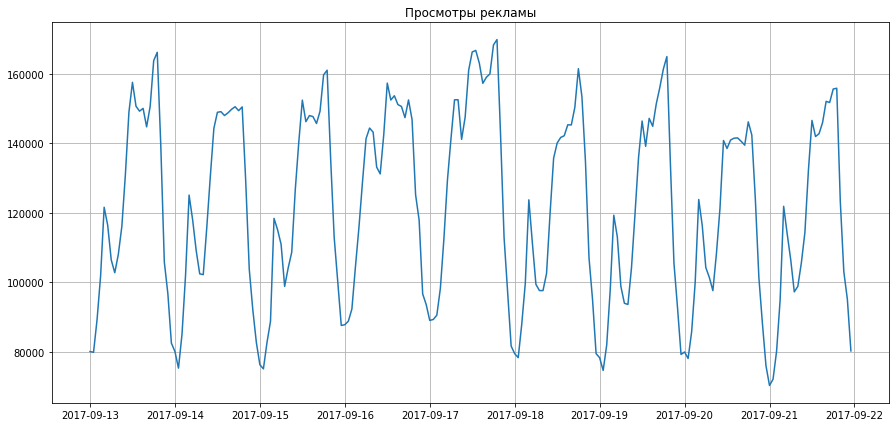

In [15]:
plt.figure(figsize=(15, 7))
plt.plot(ads.Ads)
plt.title('Просмотры рекламы')
plt.grid(True)
plt.show()

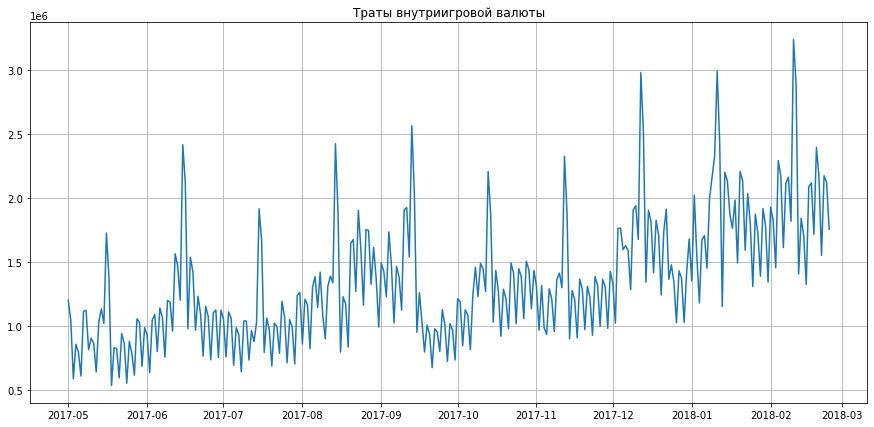

In [16]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('Траты внутриигровой валюты')
plt.grid(True)
plt.show()

## 1) Метрики качества прогноза

Рассмотрим основные и самые распространенные метрики качества прогнозов, которые, по большому счету, являются метриками для задачи регрессии и используются далеко не только во временных рядах.

- [R squared](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination), коэффициент детерминации (в эконометрике - доля объясненной моделью дисперсии), $(-\infty, 1]$

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$ 

```python
sklearn.metrics.r2_score
```
---
- [Mean Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error), интерпретируемая метрика, измеряется в тех же единицах, что и исходный ряд, $[0, +\infty)$

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$ 

```python
sklearn.metrics.mean_absolute_error
```
---
- [Median Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error), также интерпретируемая метрика, однако её преимущество - нечувствительность (робастность) к выбросам в данных, $[0, +\infty)$

$MedAE = median(|y_1 - \hat{y}_1|, ... , |y_n - \hat{y}_n|)$

```python
sklearn.metrics.median_absolute_error
```
---
- [Mean Squared Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error), используется в большинстве случаев, сильнее наказывает модель за большие ошибки и меньше - за маленькие (парабола), $[0, +\infty)$

$MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$

```python
sklearn.metrics.mean_squared_error
```
---
- [Mean Squared Logarithmic Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error), практически тоже самое, но значения предварительно логарифмируются, таким образом маленьким ошибкам также уделяется значительное внимание, обычно используется, если данным присущ экспоненциальный рост, $[0, +\infty)$

$MSLE = \frac{1}{n}\sum\limits_{i=1}^{n} (log(1+y_i) - log(1+\hat{y}_i))^2$

```python
sklearn.metrics.mean_squared_log_error
```
---
- Mean Absolute Percentage Error, как MAE, только в процентах, - удобно для объяснения заказчику качества прогноза, $[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 

```python
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
```

In [17]:
# импортируем всё, о чем говорили выше

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

теперь мы знаем, как можно измерить качество нашего прогноза, какие метрики стоит применять и как объяснить содеянное заказчику, дело осталось за малым - нужно построить прогноз

# 2) Методы сглаживания рядов

## Rolling window estimations

Начнем моделирование с наивного предположения - "завтра будет, как вчера", но вместо модели вида $\hat{y}_{t} = y_{t-1}$ будем считать, что будущее значение переменной зависит от среднего $n$ её предыдущих значений, а значит, воспользуемся скользящей средней. 

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k-1}_{n=0} y_{t-n}$

In [18]:
def moving_average(series, n):
    """
       рассчитать среднее из последних n наблюдений
    """
    return np.average(series[-n:])

In [19]:
moving_average(ads, 6) # прогноз на один шаг вперед 

118911.66666666667

К сожалению, такой прогноз долгосрочным сделать не удастся, для получения предсказания на шаг вперед предыдущее значение должно быть фактически наблюдаемой величиной. Зато у скользящей средней есть другое применение - сглаживание исходного ряда для выявления трендов, в пандасе есть готовая реализация - [`DataFrame.rolling(window).mean()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html). Чем больше зададим ширину интервала - тем более сглаженным окажется тренд. В случае, если данные сильно зашумлены, что особенно часто встречается, например, в финансовых показателях, такая процедура может помочь увидеть общие паттерны.

Применим такое сглаживание к нашим рядам

In [20]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # а имея доверительные интервалы, можно искать аномальные значения
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

Сглаживание по последним 4 часам

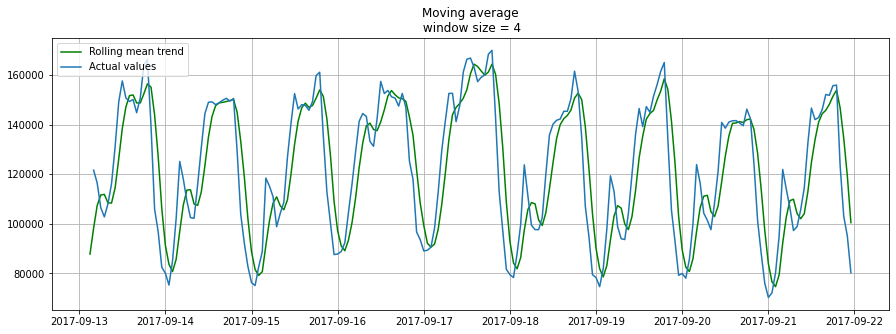

In [21]:
plotMovingAverage(ads, 4)

По 12 часам (полдня)

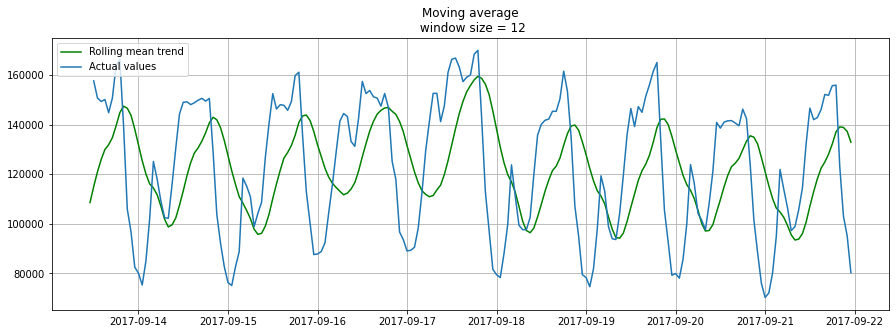

In [22]:
plotMovingAverage(ads, 12)

Сглаживание по 24 часам (одни сутки) - выделяется дневной тренд

Также можно отобразить доверительные интервалы для наших средних значений

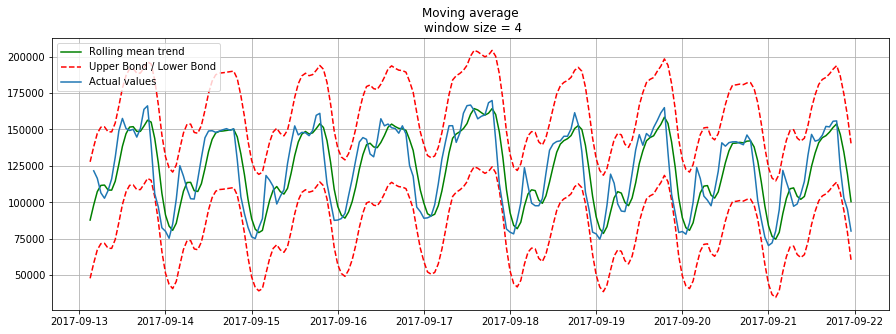

In [18]:
plotMovingAverage(ads, 4, plot_intervals=True)

А теперь попробуем при помощи этих доверительных интервалов поймать аномалию во временном ряде. К сожалению или к счастью, конкретно в этом ряду всё более-менее хорошо и гладко, поэтому аномальное значение мы зададим самостоятельно в датафрейме `ads_anomaly`

In [19]:
ads_anomaly = ads.copy()
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * 0.2 # падение показателя на 80% 

И посмотрим, удастся ли таким простым образом её поймать

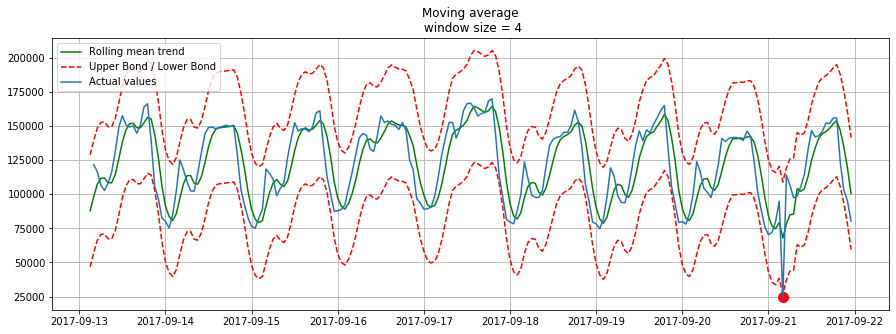

In [20]:
plotMovingAverage(ads_anomaly, 4, plot_intervals=True, plot_anomalies=True)

Тоже самое можно проделать и со вторым рядом, попробуем сгладить его с окном в 7 дней, то есть по неделям, и поймать аномалии

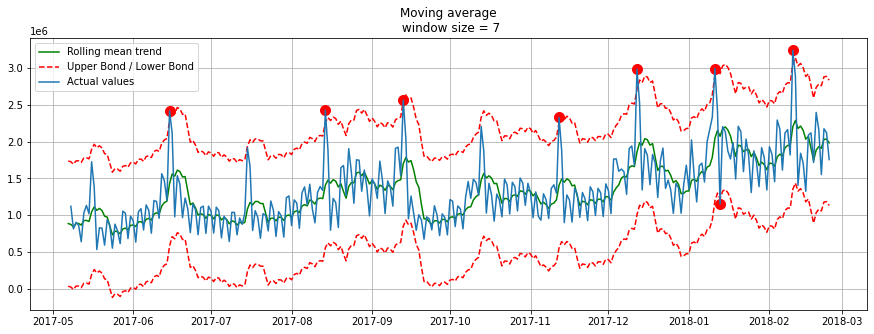

In [27]:
plotMovingAverage(currency, 7, plot_intervals=True, plot_anomalies=True)

Модификацией простой скользящей средней является взвешенная средняя, внутри которой наблюдениям придаются различные веса, в сумме дающие единицу, при этом обычно последним наблюдениям присваивается больший вес. 

Например, вчерашнее значение гораздо важнее значения предыдущего дня.

$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$

In [23]:
def weighted_average(series, weights):
    """
        Calculate weighter average on series
    """
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [28]:
weighted_average(ads, [0.6, 0.3, 0.1]) # выстраиваем веса 

NameError: name 'weighted_average' is not defined

## Экспоненциальное сглаживание

А теперь посмотрим, что произойдёт, если вместо взвешивания последних $n$ значений ряда мы начнем взвешивать все доступные наблюдения, при этом экспоненциально уменьшая веса по мере углубления в исторические данные. В этом нам поможет формула простого [экспоненциального сглаживания](http://www.machinelearning.ru/wiki/index.php?title=Экспоненциальное_сглаживание):

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

Здесь модельное значение представляет собой средневзвешенную между текущим истинным и предыдущим модельным значениями. Вес $\alpha$ называется сглаживающим фактором. Он определяет, как быстро мы будем "забывать" последнее доступное истинное наблюдение. Чем меньше $\alpha$, тем больше влияния оказывают предыдущие модельные значения, и тем сильнее сглаживается ряд. 

Экспоненциальность скрывается в рекурсивности функции - каждый раз мы умножаем $(1-\alpha)$ на предыдущее модельное значение, которое, в свою очередь, также содержало в себе $(1-\alpha)$, и так до самого начала.

In [31]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # первое значение такое же, как в исходном ряде
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [32]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

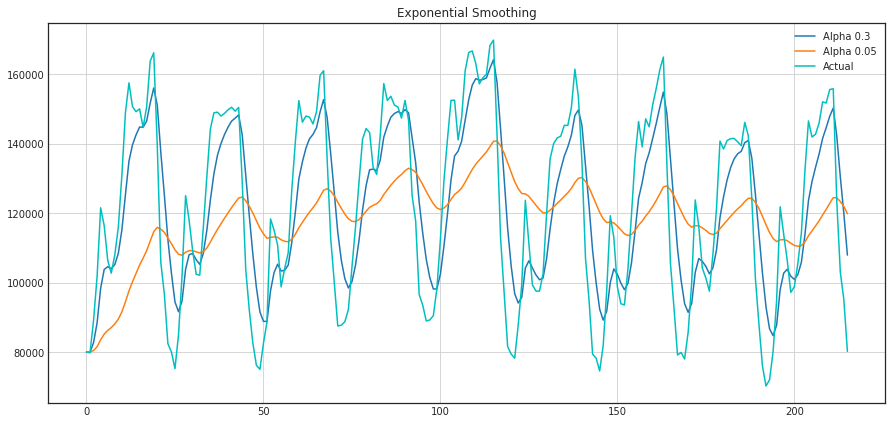

In [33]:
plotExponentialSmoothing(ads.Ads, [0.3, 0.05])

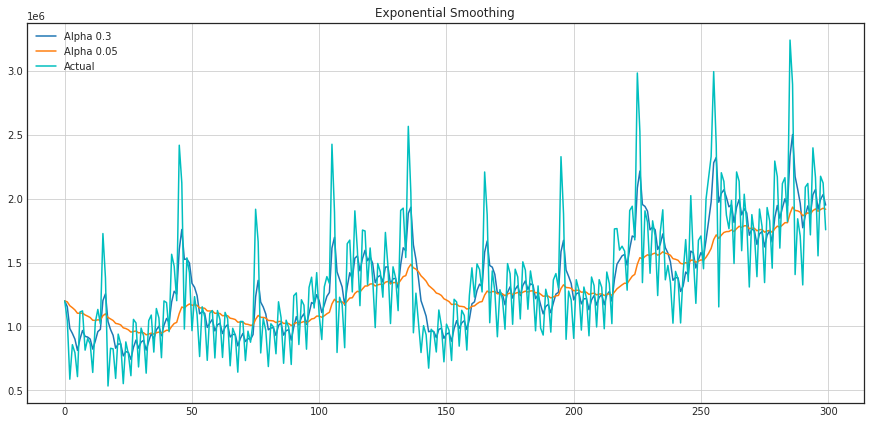

In [34]:
plotExponentialSmoothing(currency.GEMS_GEMS_SPENT, [0.3, 0.05])

ЭС плохо показывает себя на рядах с трендом.  

## Двойное экспоненциальное сглаживание

До сих пор мы могли получить от наших методов в лучшем случае прогноз лишь на одну точку вперёд (и ещё красиво сгладить ряд), это здорово, но недостаточно, поэтому переходим к расширению экспоненциального сглаживания, которое позволит строить прогноз сразу на две точки вперед (и тоже красиво сглаживать ряд).

В этом нам поможет разбиение ряда на две составляющие - уровень (level, intercept) $\ell$ и тренд $b$ (trend, slope). Уровень, или ожидаемое значение ряда, мы предсказывали при помощи предыдущих методов, а теперь такое же экспоненциальное сглаживание применим к тренду, наивно или не очень полагая, что будущее направление изменения ряда зависит от взвешенных предыдущих изменений.

$$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$\hat{y}_{x+1} = \ell_x + b_x$$

В результате получаем набор функций. Первая описывает уровень - он, как и прежде, зависит от текущего значения ряда, а второе слагаемое теперь разбивается на предыдущее значение уровня и тренда. Вторая отвечает за тренд - он зависит от изменения уровня на текущем шаге, и от предыдущего значения тренда. Здесь в роли веса в экспоненциальном сглаживании выступает коэффициент $\beta$. Наконец, итоговое предсказание представляет собой сумму модельных значений уровня и тренда.

In [38]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # первое значение такое же, как в исходном ряде
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

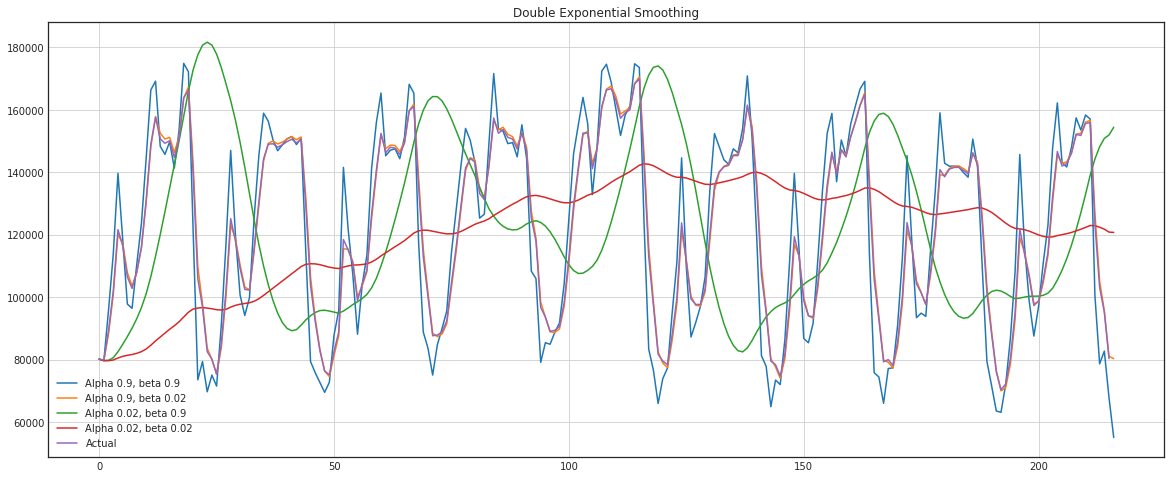

In [39]:
plotDoubleExponentialSmoothing(ads.Ads, alphas=[0.9, 0.02], betas=[0.9, 0.02])

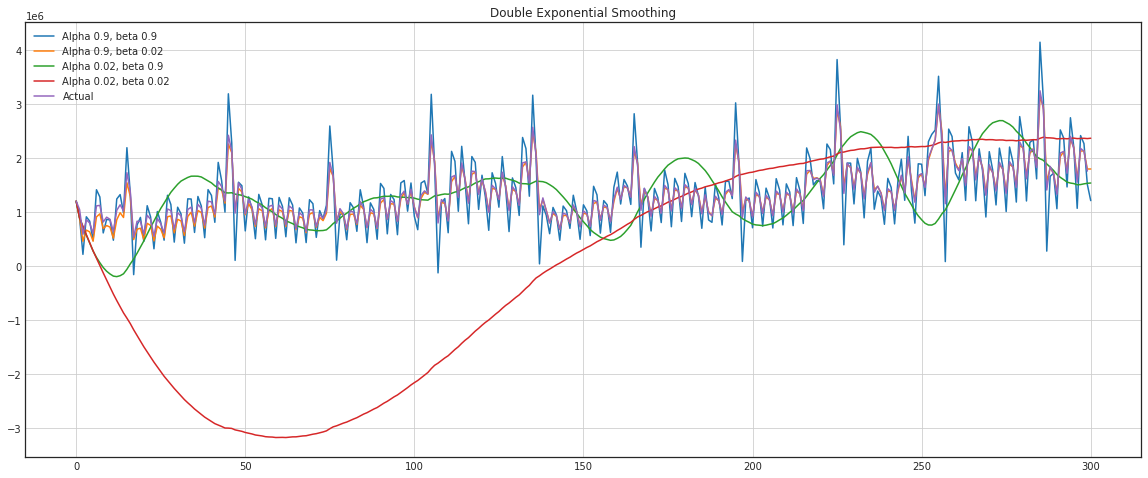

In [40]:
plotDoubleExponentialSmoothing(currency.GEMS_GEMS_SPENT, alphas=[0.9, 0.02], betas=[0.9, 0.02])

Теперь у нас появилась возможность настраивать уже два параметра - $\alpha$ и $\beta$. Первый отвечает за сглаживание ряда вокруг тренда, второй - за сглаживание самого тренда. Чем выше значения, тем больший вес будет отдаваться последним наблюдениям и тем менее сглаженным окажется модельный ряд. Комбинации параметров могут выдавать достаточно причудливые результаты, особенно если задавать их руками. 

Этот способ не очень хорошо работает с сезонностью

## Тройное экспоненциальное сглаживание a.k.a. Holt-Winters

Итак, успешно добрались до следующего варианта экспоненциального сглаживания, на сей раз тройного.

Идея этого метода заключается в добавлении еще одной, третьей, компоненты - сезонности. Сезонная компонента в модели будет объяснять повторяющиеся колебания вокруг уровня и тренда, а характеризоваться она будет длиной сезона - периодом, после которого начинаются повторения колебаний. Для каждого наблюдения в сезоне формируется своя компонента, например, если длина сезона составляет 7 (например, недельная сезонность), то получим 7 сезонных компонент, по штуке на каждый из дней недели.

Получаем новую систему:

$$\ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}$$

$$\hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}$$

Уровень теперь зависит от текущего значения ряда за вычетом соответствующей сезонной компоненты, тренд остаётся без изменений, а сезонная компонента зависит от текущего значения ряда за вычетом уровня и от предыдущего значения компоненты. При этом компоненты сглаживаются через все доступные сезоны, например, если это компонента, отвечающая за понедельник, от и усредняться она будет только с другими понедельниками. Подробнее про работу усреднений и оценку начальных значений тренда и сезонных компонент можно почитать [здесь](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm). Теперь, имея сезонную компоненту, мы можем предсказывать уже не на один, и даже не на два, а на произвольные $m$ шагов вперёд, что не может не радовать. 

Ниже импортируем класс для построения модели тройного экспоненциального сглаживания, также известного по фамилиям её создателей - Чарльза Хольта и его студента Питера Винтерса. 
Дополнительно в модель включен метод Брутлага для построения доверительных интервалов:

$$\hat y_{max_x}=\ell_{x−1}+b_{x−1}+s_{x−T}+m⋅d_{t−T}$$

$$\hat y_{min_x}=\ell_{x−1}+b_{x−1}+s_{x−T}-m⋅d_{t−T}$$

$$d_t=\gamma∣y_t−\hat y_t∣+(1−\gamma)d_{t−T}$$

где $T$ - длина сезона, $d$ - предсказанное отклонение, а остальные параметры берутся из тройного сглаживани. Подробнее о методе и о его применении к поиску аномалий во временных рядах можно прочесть [здесь](https://fedcsis.org/proceedings/2012/pliks/118.pdf)

## Кросс-валидация на временных рядах

Перед тем, как построить модель, поговорим, наконец, о неручной оценке параметров для моделей. 

Сначала необходимо выбрать подходящуюю для данной задачи функцию потерь, которая будет следить за качеством подгонки модели под исходные данные. Затем будем оценивать на кросс-валидации значение функции потерь при данных параметрах модели, искать градиент, менять в соответствии с ним параметры и бодро опускаться в сторону глобального минимума ошибки. 

Так как временной ряд внезапно имеет временную структуру, случайно перемешивать в фолдах значения всего ряда без сохранения этой структуры нельзя, иначе в процессе потеряются все взаимосвязи наблюдений друг с другом. Поэтому придется использовать чуть более хитрый способ для оптимизации параметров,  "cross-validation on a rolling basis", что не дословно можно перевести как кросс-валидация на скользящем окне.

Суть достаточно проста - начинаем обучать модель на небольшом отрезке временного ряда, от начала до некоторого $t$, делаем прогноз на $t+n$ шагов вперед и считаем ошибку. Далее расширяем обучающую выборку до $t+n$ значения и прогнозируем с $t+n$ до $t+2*n$, так продолжаем двигать тестовый отрезок ряда до тех пор, пока не упрёмся в последнее доступное наблюдение. В итоге получим столько фолдов, сколько $n$ уместится в промежуток между изначальным обучающим отрезком и всей длиной ряда.

<img src="https://habrastorage.org/files/f5c/7cd/b39/f5c7cdb39ccd4ba68378ca232d20d864.png"/>

Теперь, зная, как настраивать кросс-валидацию, подберём с её помощью параметры для модели Хольта-Винтерса

In [41]:
from sklearn.model_selection import TimeSeriesSplit # 
from HoltWinters import HoltWinters                 # 

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # вектор ошибок
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [42]:
%%time
data = ads.Ads[:-20] # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# и подставляем их в модель
model = HoltWinters(data, slen 
                    = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.11652680227350454 0.002677697431105852 0.05820973606789237
Wall time: 1.88 s


In [43]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

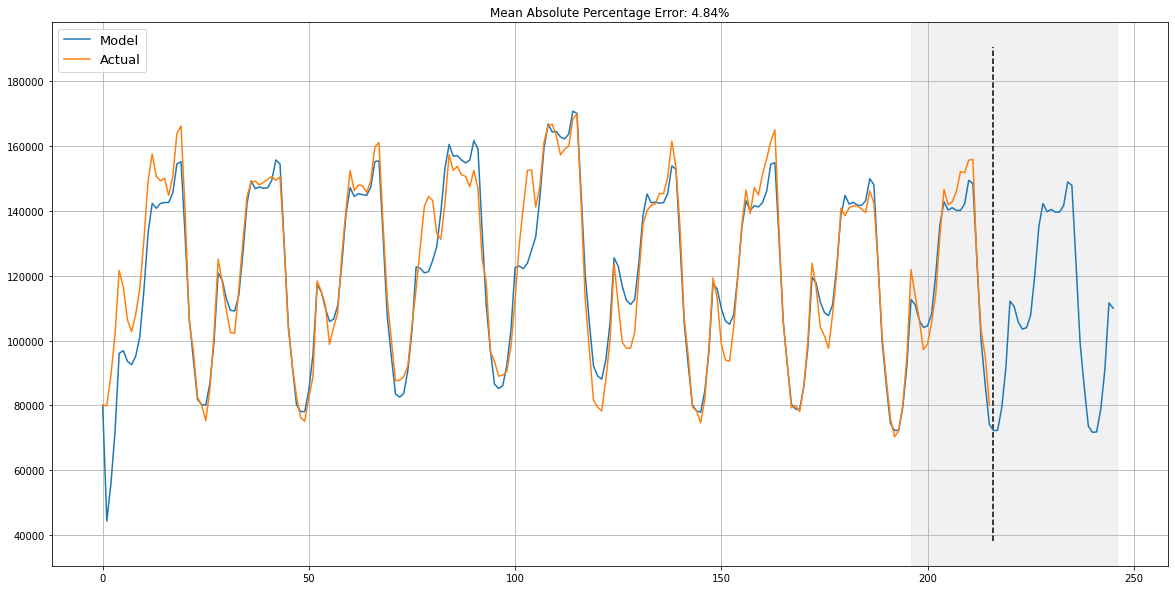

In [44]:
plotHoltWinters(ads.Ads)

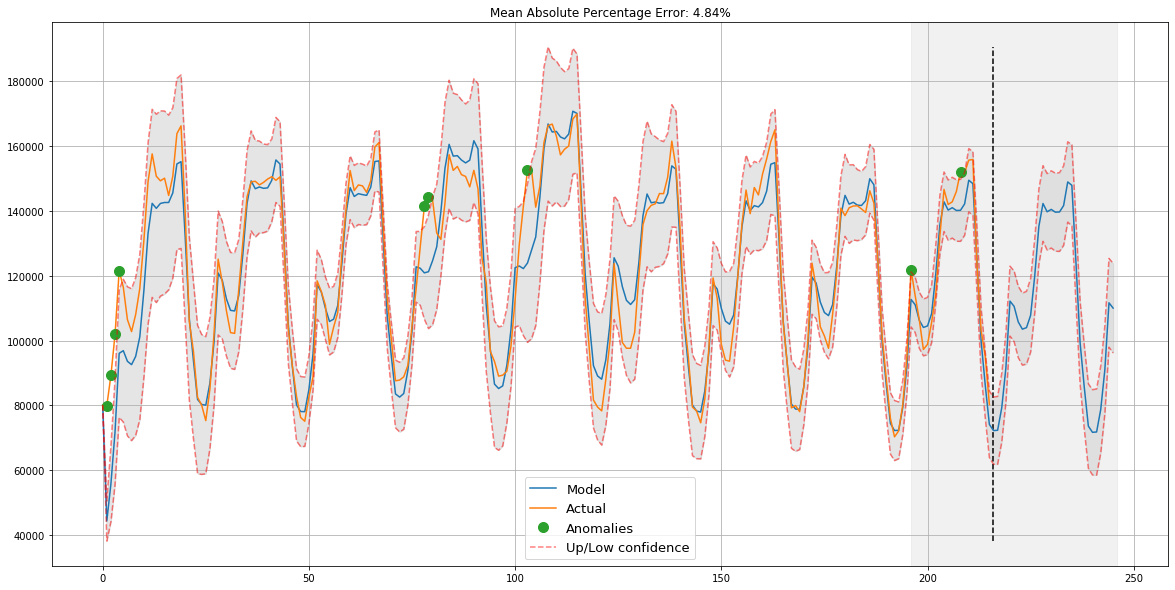

In [38]:
plotHoltWinters(ads.Ads, plot_intervals=True, plot_anomalies=True)

Если посмотреть на смоделированное отклонение, хорошо видно, что модель достаточно резко регирует на значительные изменения в структуре ряда, но при этом быстро возвращает дисперсию к обычным значениям, "забывая" прошлое. Такая особенность позволяет неплохо и без значительных затрат на подготовку-обучение модели настроить систему по детектированию аномалий даже в достаточно шумных рядах.

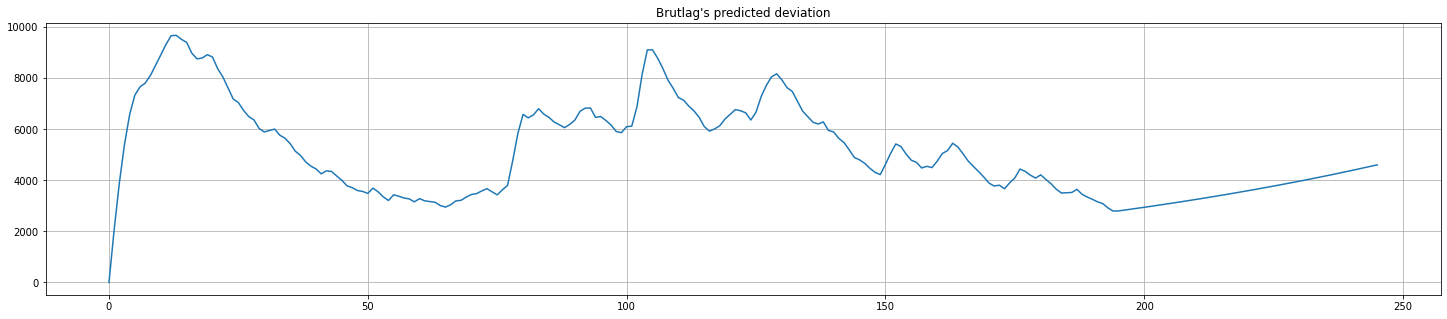

In [45]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

Прогоним тот же самый алгоритм для второго временного ряда, в котором, как мы знаем, есть тренд и месячная сезонность

In [46]:
%%time
data = currency.GEMS_GEMS_SPENT[:-50] # отложим часть данных для тестирования
slen = 30 # месячная сезонность
# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_absolute_percentage_error, slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)


model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 100, scaling_factor = 3)
model.triple_exponential_smoothing()

0.012841445048055122 0.04883371471892228 0.00943678056045777
Wall time: 2.8 s


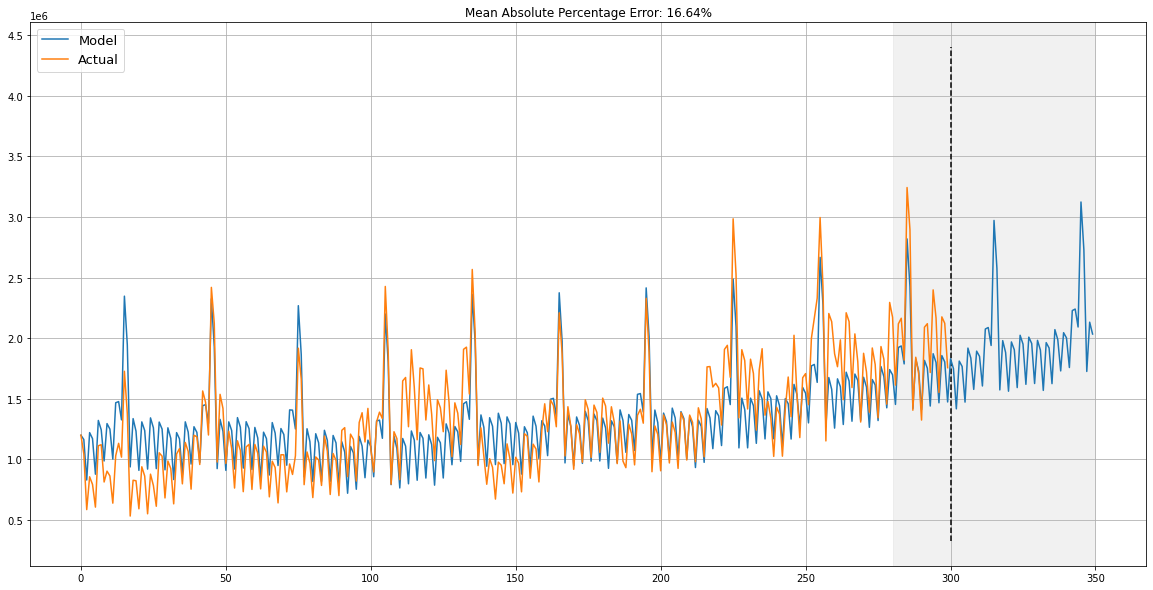

In [47]:
plotHoltWinters(currency.GEMS_GEMS_SPENT)

Выглядит весьма правдоподобно, модель уловила и восходящий тренд, и сезонные пики, и в целом достаточно точно описывает наш временной ряд

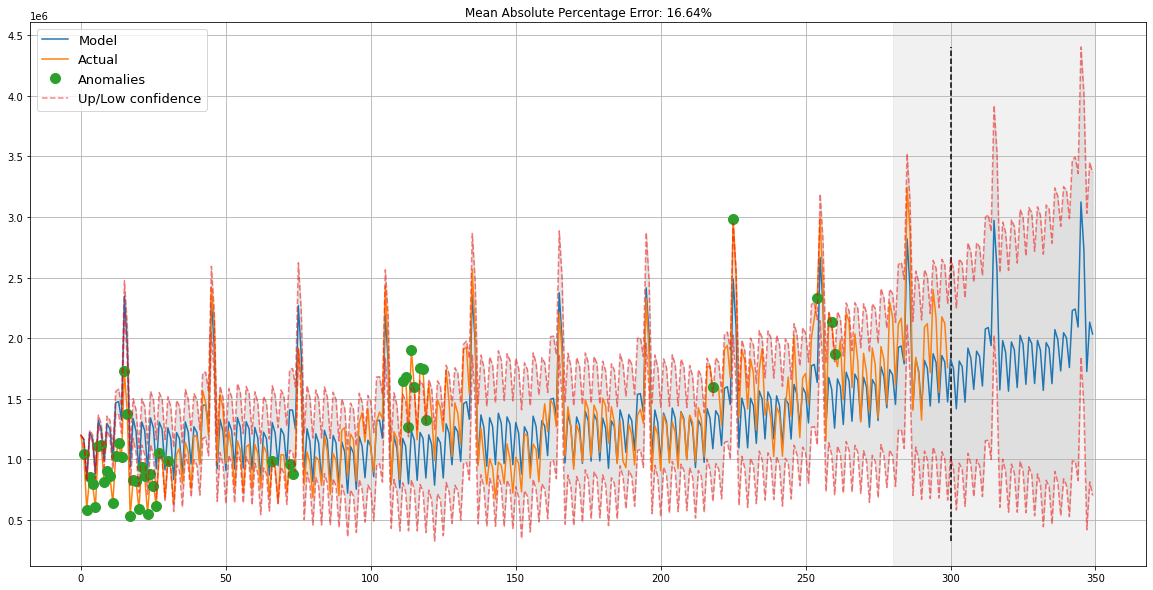

In [48]:
plotHoltWinters(currency.GEMS_GEMS_SPENT, plot_intervals=True, plot_anomalies=True)

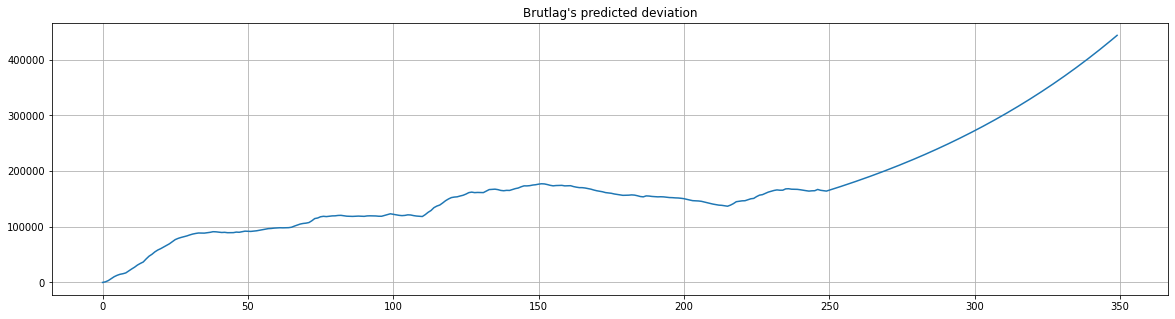

In [49]:
plt.figure(figsize=(20, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

# 3) Эконометрический подход

### Стационарность

Перед тем, как перейти к моделированию, стоит сказать о таком важном свойстве временного ряда, как [**стационарность**](https://ru.wikipedia.org/wiki/Стационарность). 
Под стационарностью понимают свойство процесса не менять своих статистических характеристик с течением времени, а именно постоянство матожидания, постоянство дисперсии (она же [гомоскедастичность](https://ru.wikipedia.org/wiki/Гомоскедастичность)) и независимость ковариационной функции от времени (должна зависеть только от расстояния между наблюдениями). Наглядно можно посмотреть на эти свойства на картинках, взятых из поста [Sean Abu](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/):

- Временной ряд справа не является стационарным, так как его матожидание со временем растёт

<img src="https://habrastorage.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png"/>

- Здесь не повезло с дисперсией - разброс значений ряда существенно варьируется в зависимости от периода

<img src="https://habrastorage.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png"/>

- Наконец, на последнем графике видно, что значения ряда внезапно становятся ближе друг ко другу, образуя некоторый кластер, а в результате получаем непостоянство ковариаций

<img src="https://habrastorage.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png"/>

Почему стационарность так важна? По стационарному ряду просто строить прогноз, так как мы полагаем, что его будущие статистические характеристики не будут отличаться от наблюдаемых текущих. Большинство моделей временных рядов так или иначе моделируют и предсказывают эти характеристики (например, матожидание или дисперсию), поэтому в случае нестационарности исходного ряда предсказания окажутся неверными. К сожалению, большинство временных рядов, с которыми приходится сталкиваться за пределыми учебных материалов, стационарными не являются, но с этим можно (и нужно) бороться.

## Избавляемся от нестационарности и строим SARIMA

Попробуем теперь построить SARIMA модель, пройдя все ~~круги ада~~ стадии приведения ряда к стационарному виду. Подробно про саму модель можно почитать здесь - [Построение модели SARIMA с помощью Python+R](https://habrahabr.ru/post/210530/), [Анализ временных рядов с помощью python](https://habrahabr.ru/post/207160/)

In [45]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])
        plt.tight_layout()

Критерий Дики-Фуллера: p=0.000000


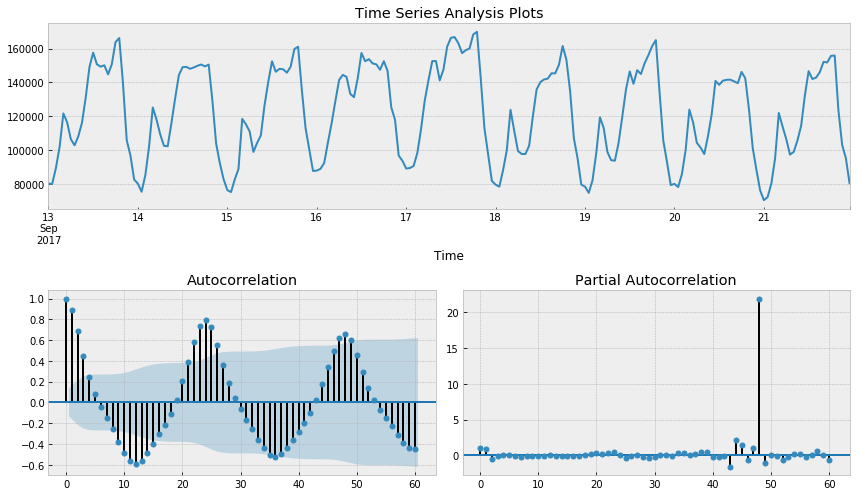

In [46]:
tsplot(ads.Ads, lags=60)

Отлично, этот ряд по критерию Дикки-Фуллера у нас стационарен, по его графику тоже видно, что тренд, как таковой, отсутствует, т.е., матожидание постоянно, разброс вокруг среднего тоже примерно одинаковый, значит, постоянство дисперсии также наблюдается. Остаётся сезонность, с которой нужно разобраться перед построением модели.
Для этого выполним преобразование под хитрым названием "сезонное дифференцирование", под которым скрывается простое вычитание из ряда самого себя с лагом равным периоду сезонности.

Критерий Дики-Фуллера: p=0.047417


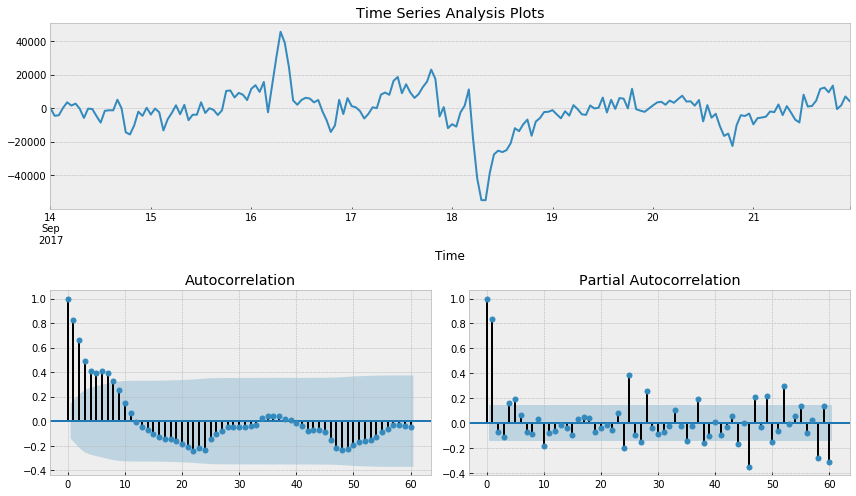

In [47]:
ads_diff = ads.Ads - ads.Ads.shift(24)
tsplot(ads_diff[24:], lags=60)

Уже лучше, от видимой сезонности избавились, в автокорреляционной функции по-прежнему осталось много значимых лагов, попробуем от них избавиться, взяв еще и первые разности - то есть вычитание ряда самого из себя с лагом в один шаг

Критерий Дики-Фуллера: p=0.000000


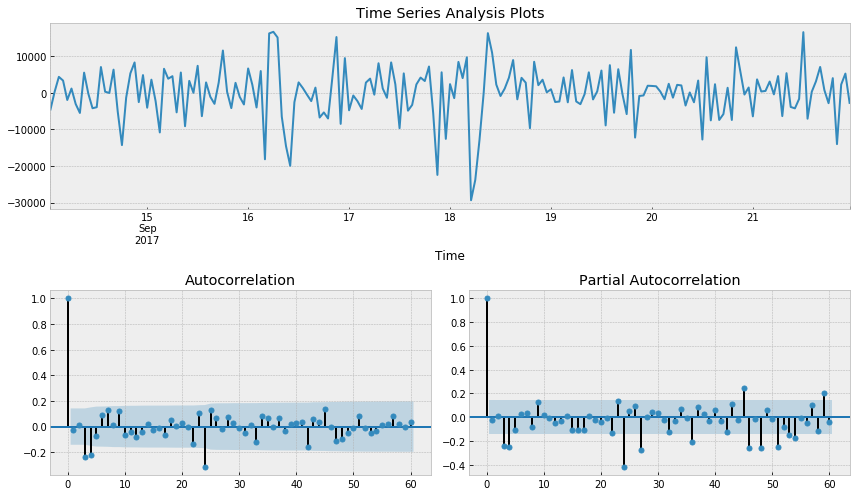

In [48]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)

Отлично, теперь ряд выглядит как непонятно что, колеблющееся вокруг нуля, по критерию Дикки-Фуллера он стационарен, а в автокорреляционной функции пропали многочисленные значимые пики. Можно приступать к моделированию! 

## Экспресс-введение в ARIMA-семейство

Cовсем вкратце о самой модели. Начнём по буквам составлять это длинное название $SARIMA(p, d, q)(P, D, Q, s)$, Seasonal Autoregression Moving Average model:

- $AR(p)$ - модель авторегрессии, т.е. регрессии временного ряда на самого себя, в основе лежит предположение о том, что временной ряд зависит от своих предыдущих значений с некоторым лагом (или с несколькими лагами), максимальный лаг, который входит в модель, обозначается буквой $p$. Определить начальное значение $p$ можно при помощи графика PACF по значимому лагу, после которого большинство оставшихся лагов становятся не значимыми.
- $MA(q)$ - модель скользящего среднего, если не вдаваться в детали - моделирует случайные ошибки временного ряда, т.е., как текущая ошибка во временном ряду зависит от предыдущих с некоторым лагом, здесь лаг обозначается буквой $q$. Начальное значение можно определить по графику ACF, логика аналогична.

Немножко остановимся и объединим первые четыре буквы, чтобы посмотреть, что у нас получилось:

$AR(p) + MA(q) = ARMA(p, q)$

А у нас получилась модель авторегрессии - скользящего среднего, если временной ряд стационарен, его можно смело аппроксимировать этими четырьмя буквами. Продолжим-с

- $I(d)$ - порядок интегрированности временного ряда. За этими словами стоит очень простая штука - сколько нам обычных разностей в ряде пришлось взять, чтобы привести его к стационарному, такой порядок интегрированности и будет. В нашем случае это единичка, так как мы взяли от нашего ряда первую разность. 

Добавим к нашим четырём буквам и получим модель $ARIMA$, которая умеет работать с нестационарными временными рядами, которые можно привести к стационарным при помощи взятия разностей некоторого порядка. Отлично, осталась последняя буква!

- $S(s)$ - эта буква отвечает за сезонность и равна длине периода сезонности во временном ряде

Прикрепляем последнюю букву и оказывается, что вместо одного дополнительного параметра у нас добавилось сразу три - $(P, D, Q)$

- $P$ - порядок модели авторегрессии для сезонной компоненты, также определяется по PACF, только смотреть нужно на число значимых лагов, кратных периоду сезонности, например, если период равен 24 и выясняется, что по PACF значим 24-й и 48-й лаг, то для начального приближения можно взять $P = 2$

- $Q$ - аналогично, но для модели скользящего среднего по сезонной компоненте, определяется по ACF

- $D$ - порядок сезонной интегрированности временного ряда. Может быть равен либо 0, либо 1, так как сезонное дифференцирование либо проводилось, либо нет

Теперь мы знаем, как подбирать параметры, еще раз посмотрим на график получившегося после преобразований стационарного ряда и попробуем подобрать начальные приближения параметров:

Критерий Дики-Фуллера: p=0.000000


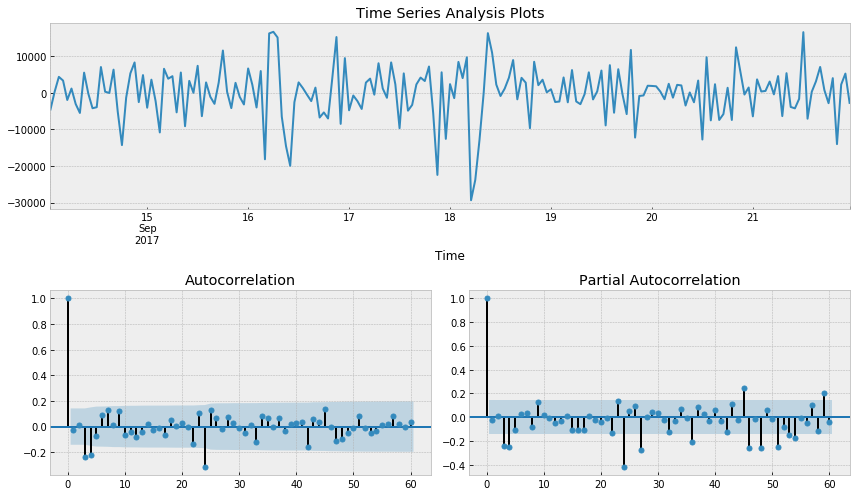

In [49]:
tsplot(ads_diff[24+1:], lags=60)

In [50]:
# p = 
# d = 
# q = 

# P = 
# D = 
# Q = 
# s = 

In [51]:
# зададим ограничения на возможные значения параметров для перебора
ps = range(2, 5)
d=1 # тут мы уверены, дифференцировали один раз
qs = range(2, 5)

Ps = range(0, 2)
D=1 # здесь тоже уверены, сезонное дифференцирование было одно
Qs = range(0, 2)
s = 24

# создадим лист с возможными параметрами и посчитаем его длину
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [52]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[3], D, param[3], s)).fit(disp=-1)
        except ValueError:
            continue
        aic = model.aic
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # сортируем по возрастанию, чем меньше критерий AIC, тем лучше
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [53]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)


Wall time: 6min 1s


In [55]:
result_table.head()

,parameters,aic
0,"(2, 3, 0, 1)",3888.642174
1,"(2, 3, 1, 1)",3888.642174
2,"(3, 2, 0, 1)",3888.763568
3,"(3, 2, 1, 1)",3888.763568
4,"(4, 2, 1, 1)",3890.279740


In [56]:
# передаём параметры с минимальным AIC
p, q, P, Q = result_table.parameters[0]

In [57]:
# обучаем лучшую модель
best_model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)

In [59]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                Ads   No. Observations:                  216
Model:             SARIMAX(2, 1, 3)x(0, 1, 1, 24)   Log Likelihood               -1941.585
Date:                            Wed, 18 Mar 2020   AIC                           3897.171
Time:                                    00:16:46   BIC                           3919.937
Sample:                                09-13-2017   HQIC                          3906.392
                                     - 09-21-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7653      0.223      3.436      0.001       0.329       1.202
ar.L2         -0.5354      0.263   

Критерий Дики-Фуллера: p=0.000000


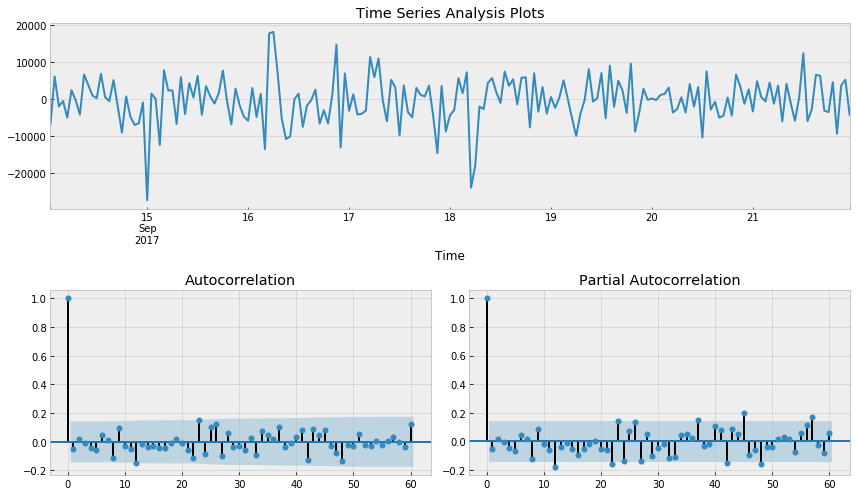

In [61]:
tsplot(best_model.resid[24+1:], lags=60)

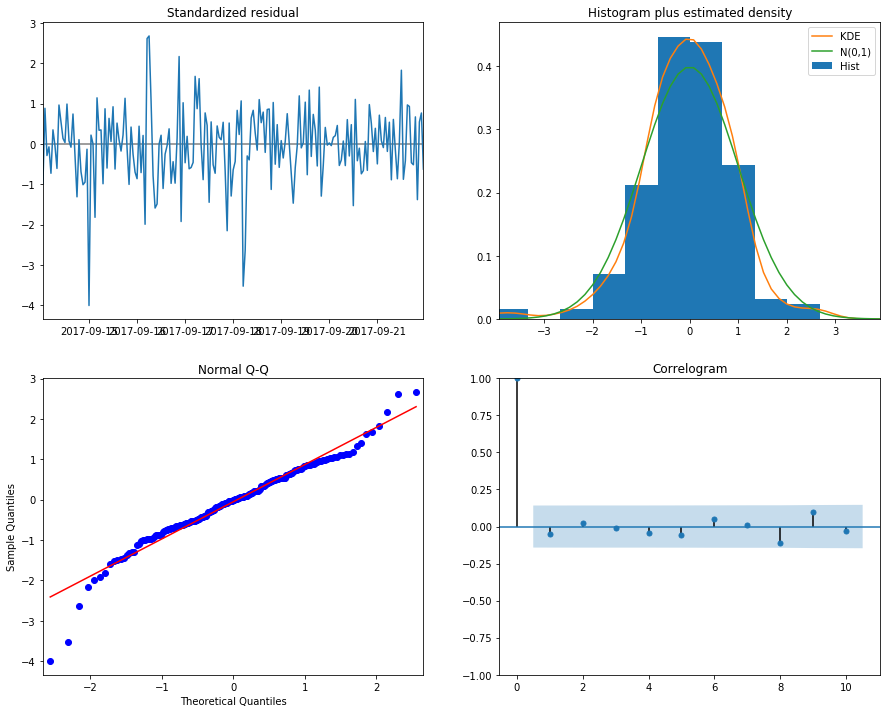

In [62]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Что ж, остатки стационарны, явных автокорреляций нет, построим прогноз по получившейся модели

In [63]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # подставляем модельные значения
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # делаем отступ на s+d, так как эти значения в модели были ненаблюдаемыми
    # из-за дифференцирования
    data['arima_model'][:s+d] = np.NaN
    
    # прогнозируем на n_steps шагов вперёд 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # считаем ошибку, также отступив s+d шагов от начала
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

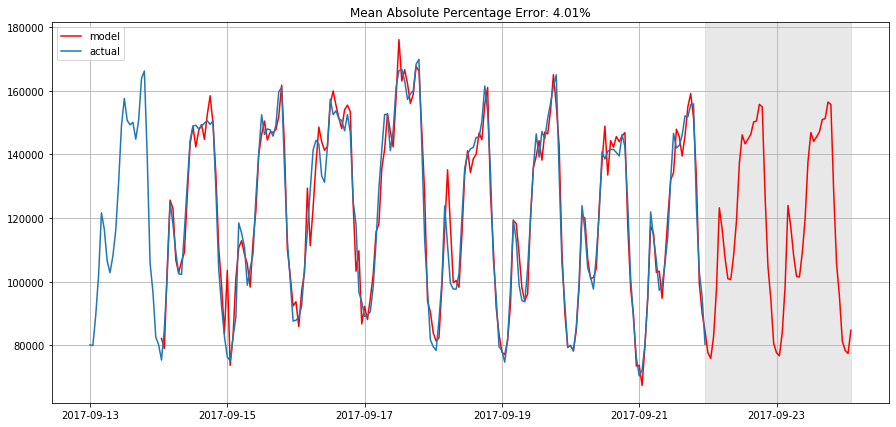

In [64]:
plotSARIMA(ads, best_model, 50)

В финале получаем очень хороший прогноз, заказчику средняя абсолютная ошибка в 4 процента также наверняка понравится, однако суммарные затраты на подготовку данных, приведение к стационарности, определение и перебор параметров могут такой точности и не стоить.